In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

file_path = "C:\\Users\\ASUS\\OneDrive\\Desktop\\OFC\\PROJECT RELATED EXCEL SHEET.xlsx"  
xls = pd.ExcelFile(file_path)

df = xls.parse("OCT 2023- FEB 25")

df["Downtime Start Time"] = pd.to_datetime(df["Downtime Start Time"], errors='coerce')
df["Downtime End Time"] = pd.to_datetime(df["Downtime End Time"], errors='coerce')

df["Inferred MTTR (Hrs)"] = (df["Downtime End Time"] - df["Downtime Start Time"]).dt.total_seconds() / 3600

high_mttr_cases = df[df["Inferred MTTR (Hrs)"] > 4][["Location Lat", "Location Long", "Inferred MTTR (Hrs)"]]
high_mttr_location_counts = high_mttr_cases.groupby(["Location Lat", "Location Long"]).size().reset_index(name="High MTTR Cases")


In [2]:
location_data = high_mttr_location_counts[["Location Lat", "Location Long"]].values
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
high_mttr_location_counts["Cluster"] = kmeans.fit_predict(location_data)

optimized_ftr_locations = kmeans.cluster_centers_

optimized_ftr_locations_df = pd.DataFrame(optimized_ftr_locations, columns=["Optimized Lat", "Optimized Long"])
print("Optimized FTR Locations:")
print(optimized_ftr_locations_df)

Optimized FTR Locations:
   Optimized Lat  Optimized Long
0      22.251742       73.013124
1      23.027694       72.696199


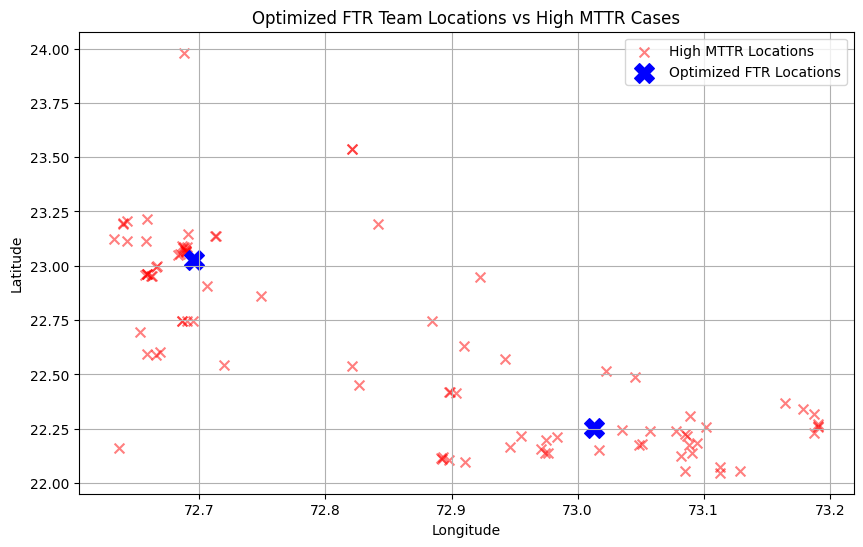

In [3]:

plt.figure(figsize=(10, 6))
plt.scatter(high_mttr_location_counts["Location Long"], high_mttr_location_counts["Location Lat"], 
            s=50, color='red',marker='x',alpha=0.5, label="High MTTR Locations")
plt.scatter(optimized_ftr_locations_df["Optimized Long"], optimized_ftr_locations_df["Optimized Lat"], 
            s=200, color='blue', marker='X', label="Optimized FTR Locations")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized FTR Team Locations vs High MTTR Cases")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import folium
from folium.plugins import MarkerCluster

map_center = [high_mttr_location_counts["Location Lat"].mean(), high_mttr_location_counts["Location Long"].mean()]
ftr_map = folium.Map(location=map_center, zoom_start=9, tiles="CartoDB positron")

marker_cluster = MarkerCluster().add_to(ftr_map)
for _, row in high_mttr_location_counts.iterrows():
    folium.Marker(
        location=[row["Location Lat"], row["Location Long"]],
        popup=f"High MTTR Cases: {row['High MTTR Cases']}",
        icon=folium.Icon(color='red', icon='exclamation-sign')
    ).add_to(marker_cluster)

for i, center in enumerate(optimized_ftr_locations):
    folium.Marker(
        location=[center[0], center[1]],
        popup=f"FTR Center {i+1}",
        icon=folium.Icon(color='green', icon='wrench')
    ).add_to(ftr_map)

ftr_map.save("FRT_Optimized_Map.html")
print("Map saved as FRT_Optimized_Map.html")

Map saved as FRT_Optimized_Map.html



 #Failure Time Analysis (MTTR Cuts by Hour of the Day)   


 Peak Failure Hours (High-Cut Periods)
9.0     19
10.0    31
11.0    25
12.0    21
14.0    20
15.0    19
16.0    24

 Moderate Failure Hours (Mid-Level Cuts) 
13.0    12
17.0    16
18.0    11
19.0    10

 Low Failure Hours (Least-Cut Periods) 
0.0     1
1.0     4
2.0     2
3.0     3
4.0     5
5.0     4
6.0     5
7.0     3
8.0     3
20.0    9
21.0    6
22.0    4
23.0    1


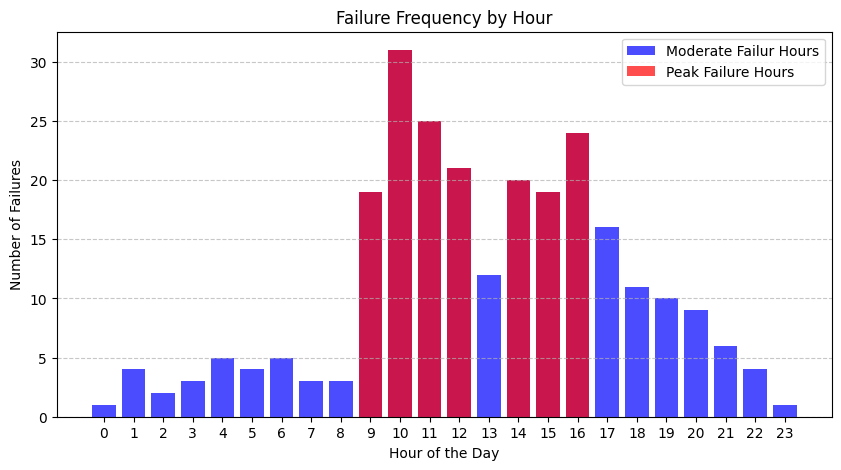

In [4]:
df["Failure Hour"] = df["Downtime Start Time"].dt.hour

failure_time_distribution = df["Failure Hour"].value_counts().sort_index()
print("\n #Failure Time Analysis (MTTR Cuts by Hour of the Day)   \n")

peak_hours = failure_time_distribution[failure_time_distribution >= 19]
moderate_hours = failure_time_distribution[(failure_time_distribution >= 10) & (failure_time_distribution < 19)]
low_hours = failure_time_distribution[failure_time_distribution < 10]
print("\n Peak Failure Hours (High-Cut Periods)")
print(peak_hours.to_string(header=False))
print("\n Moderate Failure Hours (Mid-Level Cuts) ")
print(moderate_hours.to_string(header=False))
print("\n Low Failure Hours (Least-Cut Periods) ")
print(low_hours.to_string(header=False))

plt.figure(figsize=(10, 5))
plt.bar(failure_time_distribution.index, failure_time_distribution.values, color='blue', alpha=0.7, label="Moderate Failur Hours")
plt.bar(peak_hours.index, peak_hours.values, color='red', alpha=0.7, label="Peak Failure Hours")

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Failures")
plt.title("Failure Frequency by Hour")
plt.xticks(range(0, 24))  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_36148\3407310237.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="coolwarm")


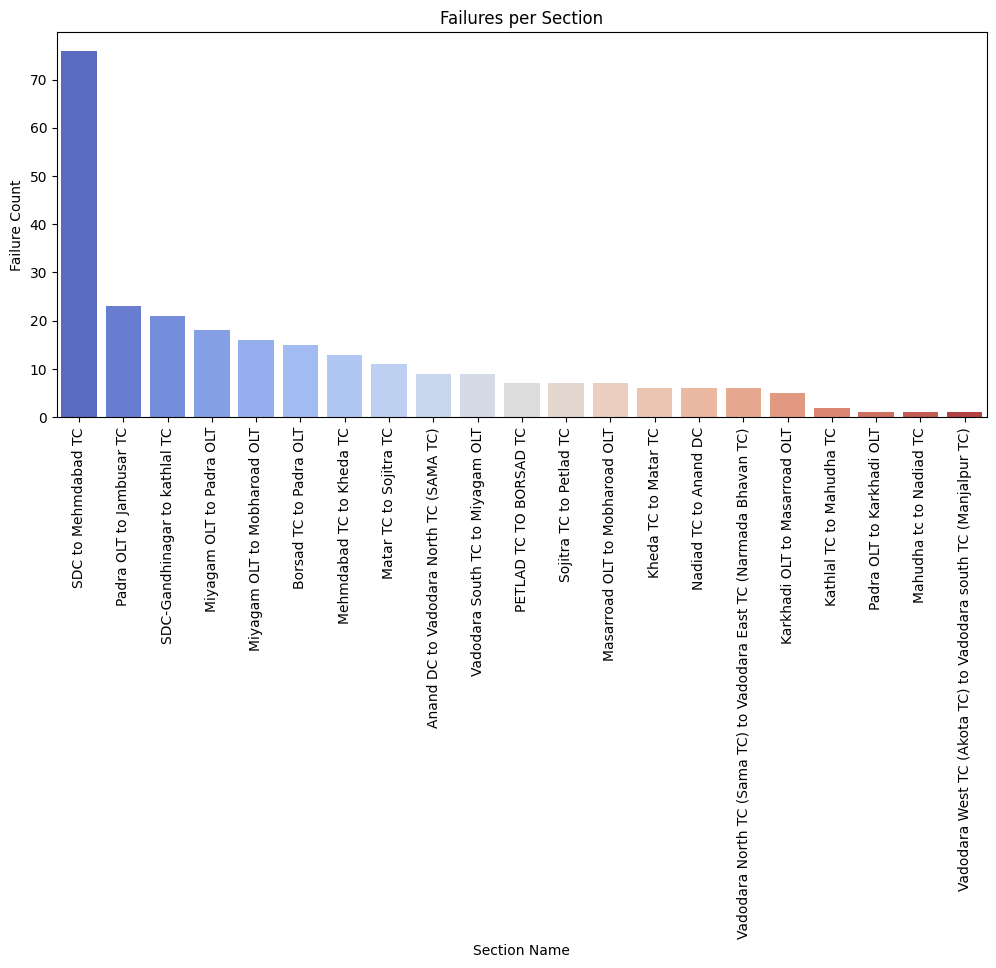

C:\Users\ASUS\AppData\Local\Temp\ipykernel_36148\3407310237.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mttr_per_section.index, y=mttr_per_section.values, palette="viridis")


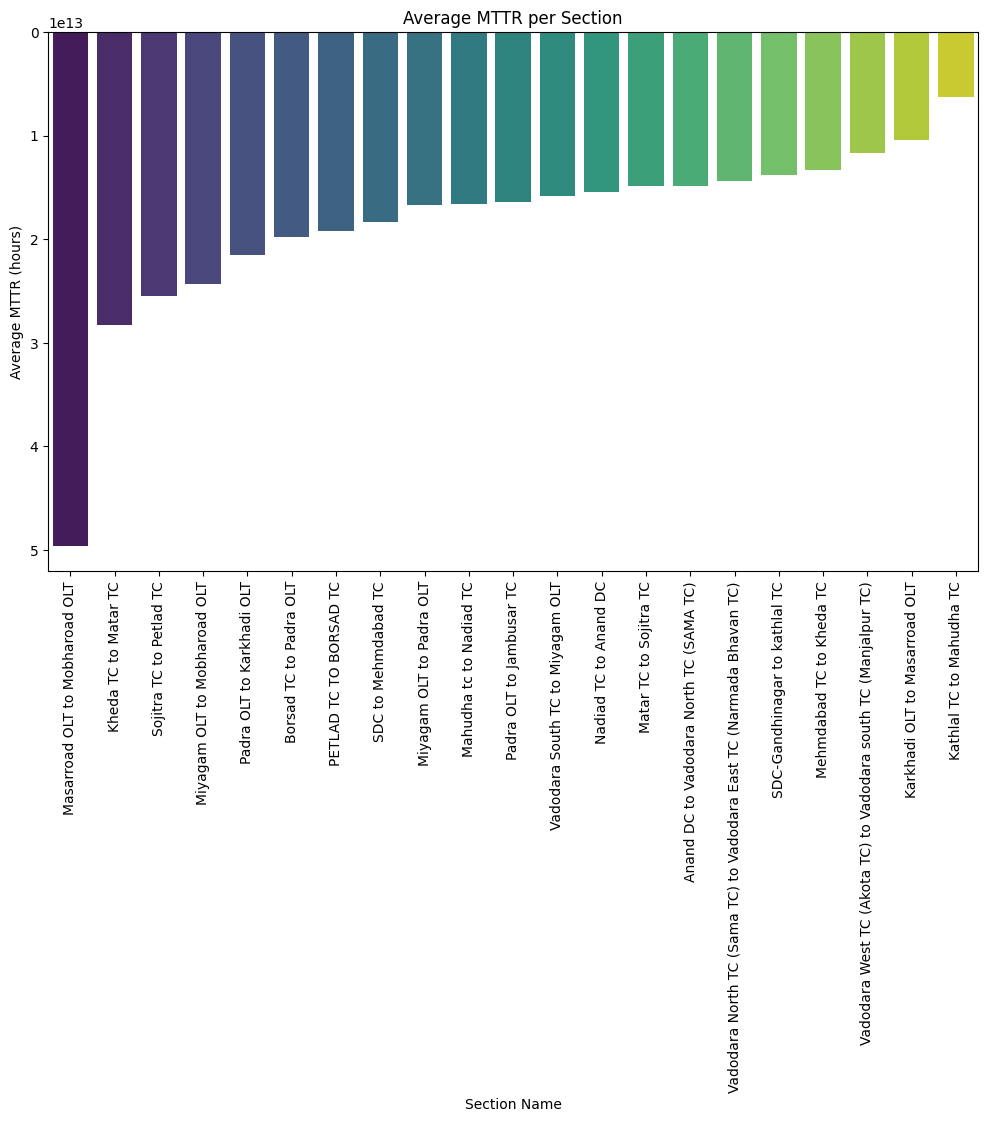

In [5]:
import seaborn as sns
failure_counts = df["Section Name"].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Section Name")
plt.ylabel("Failure Count")
plt.title("Failures per Section")
plt.show()

mttr_per_section = df.groupby("Section Name")["Fiber Cut MTTR(Hrs)"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=mttr_per_section.index, y=mttr_per_section.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Section Name")
plt.ylabel("Average MTTR (hours)")
plt.title("Average MTTR per Section")
plt.show()

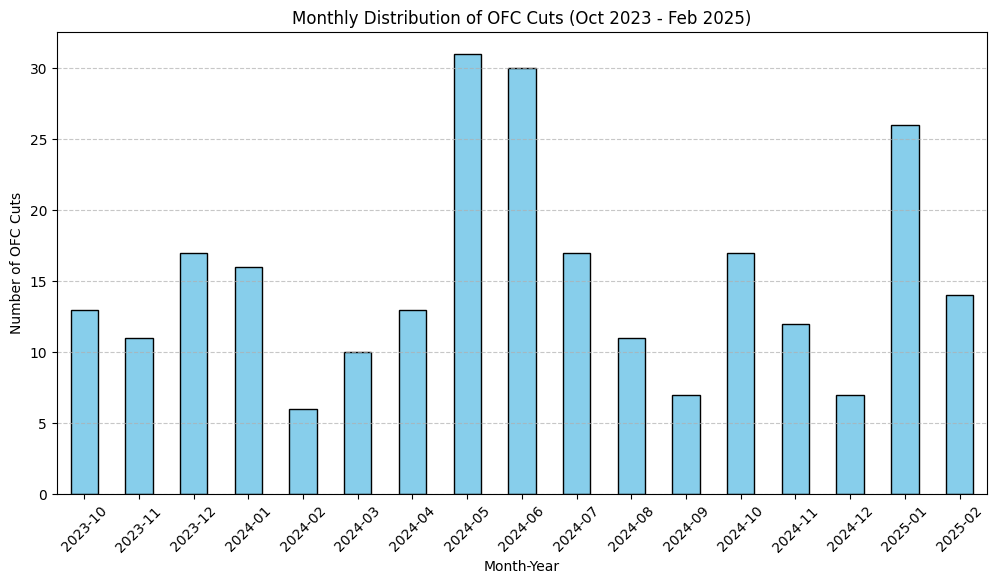

In [6]:
df["Downtime Start Time"] = pd.to_datetime(df["Downtime Start Time"], errors="coerce")
df["Month-Year"] = df["Downtime Start Time"].dt.to_period("M")
monthly_distribution = df["Month-Year"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_distribution.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Month-Year")
plt.ylabel("Number of OFC Cuts")
plt.title("Monthly Distribution of OFC Cuts (Oct 2023 - Feb 2025)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
